# **Mask RCNN**

## **Importing Modules**

In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mrcnn import visualize
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from IPython.display import clear_output

Using TensorFlow backend.


## **Loading dataset & Model configuration**

In [3]:
# Root directory of the project
ROOT_DIR = os.getcwd()
DATASET_DIR = os.path.join(ROOT_DIR,"Dataset")

sys.path.append(ROOT_DIR)

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR,"mask_rcnn_coco.h5")
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)

# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR,"logs")

In [4]:
class CustomConfig(Config):
    NAME = "object"

    # Processing no of images based on GPU configuration
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 102
    
    # Number of validation steps per epoch
    VALIDATION_STEPS = 25
    
    USE_MINI_MASK = False
    
    TRAIN_ROIS_PER_IMAGE = 128
    
    MASK_SHAPE = [56, 56]

In [5]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        # Adding classes
        self.add_class("object", 1, "Potato_Early_Blight")
        self.add_class("object", 2, "Potato_Healthy")
        self.add_class("object", 3, "Potato_Late_Blight")
        self.add_class("object", 4, "Tomato_Healthy")
        self.add_class("object", 5, "Tomato_Leaf_Mold")
        self.add_class("object", 6, "Tomato_Leaf_Spot")

        # Setting up dataset path
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Loading JSON file
        annotations1 = json.load(open(os.path.join(dataset_dir, 'annotations.json')))
        annotations = list(annotations1.values())

        # Getting images with annotations
        annotations = [a for a in annotations if a['regions']]

        # Getting x and y coordinates of polygon (regions)
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Potato_Early_Blight": 1,"Potato_Healthy": 2,"Potato_Late_Blight": 3,
                         "Tomato_Healthy": 4,"Tomato_Leaf_Mold": 5,"Tomato_Leaf_Spot": 6}

            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    # Generating instance masks for an image
    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Getting indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## **Training Model**

In [6]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

# Training dataset.
dataset_train = CustomDataset()

dataset_train.load_custom(DATASET_DIR,"train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(DATASET_DIR, "val")
dataset_val.prepare()
clear_output()

In [7]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=5,
            layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\AMWagle\Plant_Health\Plant_Health_MaskRCNN\logs\object20230110T1509\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch

C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/5
102/102 [==============================] - 6600s 65s/step - loss: 2.2326 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.5418 - mrcnn_bbox_loss: 0.6773 - mrcnn_mask_loss: 0.6854 - val_loss: 1.8416 - val_rpn_class_loss: 0.0272 - val_rpn_bbox_loss: 0.3796 - val_mrcnn_class_loss: 0.3615 - val_mrcnn_bbox_loss: 0.4120 - val_mrcnn_mask_loss: 0.6613

Epoch 2/5
102/102 [==============================] - 6560s 64s/step - loss: 1.6089 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2593 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.4233 - mrcnn_mask_loss: 0.6341 - val_loss: 1.4634 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.2379 - val_mrcnn_class_loss: 0.2077 - val_mrcnn_bbox_loss: 0.3989 - val_mrcnn_mask_loss: 0.6081
Epoch 3/5
102/102 [==============================] - 6520s 64s/step - loss: 1.4766 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2516 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.6130 - val_loss: 1.1989 - val_rpn

In [8]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='all')


Starting at epoch 5. LR=0.001

Checkpoint Path: C:\Users\AMWagle\Plant_Health\Plant_Health_MaskRCNN\logs\object20230110T1509\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch

SGD Optimizer


C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 6/10
102/102 [==============================] - 6104s 60s/step - loss: 1.0970 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1625 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.2749 - mrcnn_mask_loss: 0.4608 - val_loss: 1.1309 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.1875 - val_mrcnn_class_loss: 0.2279 - val_mrcnn_bbox_loss: 0.2645 - val_mrcnn_mask_loss: 0.4386
Epoch 7/10
102/102 [==============================] - 6221s 61s/step - loss: 1.0056 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2584 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.3719 - val_loss: 1.0585 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.2823 - val_mrcnn_class_loss: 0.1902 - val_mrcnn_bbox_loss: 0.2515 - val_mrcnn_mask_loss: 0.3262
Epoch 8/10
102/102 [==============================] - 6495s 64s/step - loss: 0.9241 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1873 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.2582 - mrcnn_mask_loss: 0.3222 - val_loss: 1.1250 - val_rpn_c

In [9]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=15,
            layers='all')


Starting at epoch 10. LR=0.001

Checkpoint Path: C:\Users\AMWagle\Plant_Health\Plant_Health_MaskRCNN\logs\object20230110T1509\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

SGD Optimizer


C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 11/15
102/102 [==============================] - 6965s 68s/step - loss: 0.8632 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.1897 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.2675 - val_loss: 0.8682 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.2022 - val_mrcnn_class_loss: 0.1726 - val_mrcnn_bbox_loss: 0.2405 - val_mrcnn_mask_loss: 0.2454
Epoch 12/15
102/102 [==============================] - 7768s 76s/step - loss: 0.7808 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2370 - val_loss: 0.7654 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.1811 - val_mrcnn_class_loss: 0.1377 - val_mrcnn_bbox_loss: 0.2220 - val_mrcnn_mask_loss: 0.2200
Epoch 13/15
102/102 [==============================] - 7772s 76s/step - loss: 0.7706 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1561 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.2312 - val_loss: 0.8274 - val_rp

In [10]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='all')


Starting at epoch 15. LR=0.001

Checkpoint Path: C:\Users\AMWagle\Plant_Health\Plant_Health_MaskRCNN\logs\object20230110T1509\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

SGD Optimizer


C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 16/20
102/102 [==============================] - 10413s 102s/step - loss: 0.6979 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.2094 - val_loss: 0.5085 - val_rpn_class_loss: 0.0036 - val_rpn_bbox_loss: 0.1468 - val_mrcnn_class_loss: 0.0768 - val_mrcnn_bbox_loss: 0.1200 - val_mrcnn_mask_loss: 0.1614
Epoch 17/20
102/102 [==============================] - 9982s 98s/step - loss: 0.6970 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1624 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1886 - mrcnn_mask_loss: 0.1967 - val_loss: 0.7861 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.1373 - val_mrcnn_class_loss: 0.1983 - val_mrcnn_bbox_loss: 0.2334 - val_mrcnn_mask_loss: 0.2097
Epoch 18/20
102/102 [==============================] - 10141s 99s/step - loss: 0.7037 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.2144 - val_loss: 0.5886 - val

In [11]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=25,
            layers='all')


Starting at epoch 20. LR=0.001

Checkpoint Path: C:\Users\AMWagle\Plant_Health\Plant_Health_MaskRCNN\logs\object20230110T1509\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

SGD Optimizer


C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\AMWagle\ac39\envs\p_37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 21/25
102/102 [==============================] - 45583s 447s/step - loss: 0.6300 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.1693 - mrcnn_mask_loss: 0.2063 - val_loss: 0.8802 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.2234 - val_mrcnn_class_loss: 0.1685 - val_mrcnn_bbox_loss: 0.2293 - val_mrcnn_mask_loss: 0.2510
Epoch 22/25
102/102 [==============================] - 14216s 139s/step - loss: 0.7093 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1551 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.1825 - mrcnn_mask_loss: 0.2132 - val_loss: 0.6230 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.1470 - val_mrcnn_class_loss: 0.1228 - val_mrcnn_bbox_loss: 0.1585 - val_mrcnn_mask_loss: 0.1881
Epoch 23/25
102/102 [==============================] - 13566s 133s/step - loss: 0.6189 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.1992 - val_loss: 0.6383 - 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## **Testing Model**

In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mrcnn import visualize
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from IPython.display import clear_output 

Using TensorFlow backend.


In [2]:
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap, compute_recall
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

In [3]:
ROOT_DIR = os.getcwd()

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

CUSTOM_DIR = os.path.join(ROOT_DIR, "Dataset")

In [4]:
class CustomConfig(Config):
    NAME = "object"

    # Processing no of images based on GPU configuration
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6
    
    USE_MINI_MASK = False
    
    MASK_SHAPE = [56, 56]

In [5]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        # Adding classes
        self.add_class("object", 1, "Potato_Early_Blight")
        self.add_class("object", 2, "Potato_Healthy")
        self.add_class("object", 3, "Potato_Late_Blight")
        self.add_class("object", 4, "Tomato_Healthy")
        self.add_class("object", 5, "Tomato_Leaf_Mold")
        self.add_class("object", 6, "Tomato_Leaf_Spot")

        # Setting up dataset path
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Loading JSON file
        annotations1 = json.load(open(os.path.join(dataset_dir, 'annotations.json')))
        annotations = list(annotations1.values())

        # Getting images with annotations
        annotations = [a for a in annotations if a['regions']]

        # Getting x and y coordinates of polygon (regions)
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Potato_Early_Blight": 1,"Potato_Healthy": 2,"Potato_Late_Blight": 3,
                         "Tomato_Healthy": 4,"Tomato_Leaf_Mold": 5,"Tomato_Leaf_Spot": 6}

            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    # Generating instance masks for an image
    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Getting indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
clear_output()

In [15]:
# Loading model
config = CustomConfig()
model_ = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

weights_path = os.path.join(MODEL_DIR, "object20230110T1509/mask_rcnn_object_0025.h5")
model_.load_weights(weights_path, by_name=True)
clear_output()

In [16]:
def get_ax(rows=1, cols=1, size=12):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [17]:
# Display results
def detect_hlth(pth):
    image1 = mpimg.imread(pth)
    results1 = model_.detect([image1], verbose=1)
    ax = get_ax(1)
    r1 = results1[0]
    lbl_list=["Potato_Early_Blight","Potato_Healthy","Potato_Late_Blight","Tomato_Healthy","Tomato_Leaf_Mold",
              "Tomato_Leaf_Spot","Detection Error: Unable to detect, Try again with valid image",""]
    
    empty_list=["","","","","","",""]
    try:
        cls_value=r1['class_ids'][0]
    except IndexError:
        cls_value=7

    if cls_value==1:
        c1=lbl_list[0]
        c2,c3,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==2:
        c2=lbl_list[1]
        c1,c3,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==3:
        c3=lbl_list[2]
        c1,c2,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==4:
        c4=lbl_list[3]
        c1,c2,c3,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==5:
        c5=lbl_list[4]
        c1,c2,c3,c4,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==6:
        c6=lbl_list[5]
        c1,c2,c3,c4,c5,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    else:
        err=lbl_list[6]
        c1,c2,c3,c4,c5,c6=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    
    visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],empty_list,r1['scores'], 
                                ax=ax,title=c1 or c2 or c3 or c4 or c5 or c6  or err)

Enter potato or tomato leaf image:"C:\Users\AMWagle\Plant_Health\Plant_Health_MaskRCNN\Test\tlm(2).JPG"
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


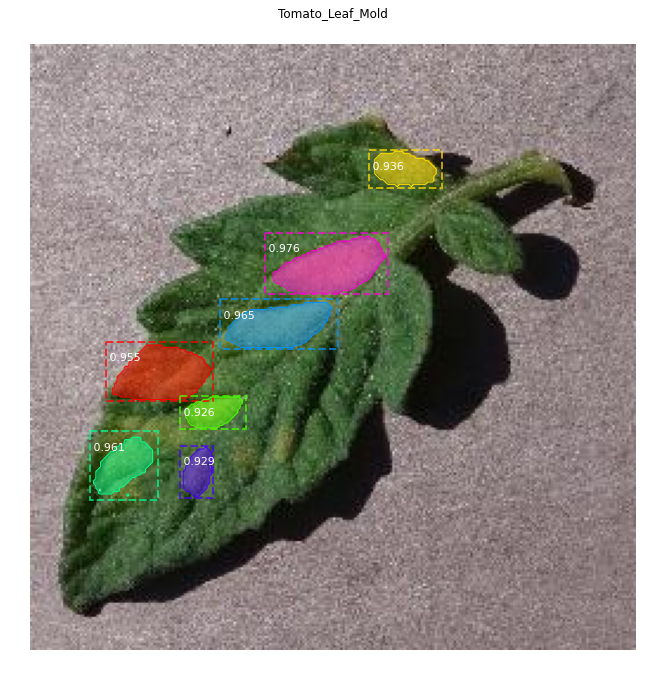

In [19]:
pth = input("Enter potato or tomato leaf image:")
pth2 = pth.replace('"','')
detect_hlth(pth2)

## **Evaluation**

In [14]:
# Evaluation
APs = list()
ARs = list()
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, config, image_id, use_mini_mask=False)
    scaled_image = mold_image(image, config)
    sample = expand_dims(scaled_image, 0)
    yhat = model_.detect(sample, verbose=0)
    r = yhat[0]
    AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                   r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    AR, positive_ids = compute_recall(r["rois"], gt_bbox)
    ARs.append(AR)
    
mAP = mean(APs)
mAR = mean(ARs)

In [6]:
print("Accuracy (mAP):",round(mAP,3))

Accuracy (mAP): 0.845


In [7]:
#F1-Score
F1_score_= (2 * mAP * mAR)/(mAP + mAR)
print("F1 Score:",round(F1_score,3))

F1 Score: 0.871
